In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import yaml
from matplotlib import pyplot as plt

In [2]:
# Categories as specified in the dataset are different to the paper
# This gives the mapping between them
cat_correction = {20: 34,
                  21: 20,
                  22: 21,
                  23: 22,
                  24: 23,
                  25: 24,
                  26: 25,
                  27: 26,
                  28: 27,
                  29: 28,
                  30: 29,
                  31: 30,
                  32: 31,
                  33: 32,
                  34: 33}

In [3]:
# Map categories to error severity
# Severity is as specified in the paper
with open("cat_severity.yaml") as stream:
    try:
        cat_severity = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

### Load results from DEMETR paper

In [4]:
demetr_results = "../data/demetr_paper_results_tidy.csv"

In [5]:
demetr_df = pd.read_csv(demetr_results)
demetr_df.head(1)

,metric,type,accuracy,category
0,Bleu,string,93.2,1


In [6]:
bleu_baseline = demetr_df[demetr_df.metric == 'Bleu']
comet_baseline = demetr_df[demetr_df.metric == 'Comet']

In [7]:
comet_baseline.head(5)

,metric,type,accuracy,category
9,Comet,learned,99.1,1
22,Comet,learned,100.0,2
35,Comet,learned,91.2,3
48,Comet,learned,99.2,4
61,Comet,learned,95.5,5


In [8]:
bleu_baseline.head(5)

,metric,type,accuracy,category
0,Bleu,string,93.2,1
13,Bleu,string,95.7,2
26,Bleu,string,69.5,3
39,Bleu,string,73.1,4
52,Bleu,string,79.2,5


In [9]:
# Sort and sanity check
# We should have 35 categories
bleu_baseline = bleu_baseline.sort_values('category')
print(len(bleu_baseline))

comet_baseline = comet_baseline.sort_values('category')
print(len(comet_baseline))

35
35


### Load M4ST results

In [85]:
m4st_res_dir = "../outputs/demetr"

In [86]:
res_files = os.listdir(m4st_res_dir)

In [87]:
# Read all files into a single dataframe
metric = res_files[0].split('_')[0]
id = next(c for c in res_files[0].split('_') if 'id' in c)
cat = int(id.strip('id'))
all_res = pd.read_json(os.path.join(m4st_res_dir, res_files[0]))
all_res = all_res.T
all_res['metric'] = metric
all_res['sentence_id'] = all_res.index
all_res['category'] = cat

for i in range(1, len(res_files)):
    try:
        res_df = pd.read_json(os.path.join(m4st_res_dir, res_files[i]))
        metric = res_files[i].split('_')[0]
        id = next(c for c in res_files[i].split('_') if 'id' in c)
        cat = int(id.strip('id'))
        res_df = res_df.T
        res_df['metric'] = metric
        res_df['sentence_id'] = res_df.index
        res_df['category'] = cat
        all_res = pd.concat([all_res, res_df])
    except IsADirectoryError:
        pass

In [88]:
all_res.head(1)

,source_language,mt_score,disfluent_score,metric,sentence_id,category
1,chinese_simple,73.613919,19.173356,ChrF1,1,34


In [89]:
# Correct categories to align with the paper
all_res['category'] = all_res['category'].replace(cat_correction)

In [90]:
all_res.head(1)

,source_language,mt_score,disfluent_score,metric,sentence_id,category
1,chinese_simple,73.613919,19.173356,ChrF1,1,33


In [91]:
# Add column indicating DEMETR accuracy
all_res['correct'] = all_res['mt_score'] > all_res['disfluent_score']

In [92]:
# Accuracy is reversed for category 35 (reference as translation) so need to adjust that
cat_to_rev = all_res.loc[all_res['category'] == 35]
cat_to_rev

,source_language,mt_score,disfluent_score,metric,sentence_id,category,correct
601,czech,4.097744,3.907722,BLASER,601,35,True
602,czech,4.709267,4.441699,BLASER,602,35,True
603,czech,4.352407,3.300454,BLASER,603,35,True
604,czech,4.54844,4.415883,BLASER,604,35,True
605,czech,4.099782,4.030355,BLASER,605,35,True
...,...,...,...,...,...,...,...
996,italian,74.188438,100.0,ChrF2,996,35,False
997,italian,69.348646,100.0,ChrF2,997,35,False
998,italian,51.522835,100.0,ChrF2,998,35,False
999,italian,93.826029,100.0,ChrF2,999,35,False


In [93]:
cat_to_rev['correct'] = cat_to_rev['mt_score'] < cat_to_rev['disfluent_score']
cat_to_rev

/var/folders/z4/mf_7gqbs75d6y4sj_xb9t80w0000gr/T/ipykernel_77707/3866171138.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_to_rev['correct'] = cat_to_rev['mt_score'] < cat_to_rev['disfluent_score']


,source_language,mt_score,disfluent_score,metric,sentence_id,category,correct
601,czech,4.097744,3.907722,BLASER,601,35,False
602,czech,4.709267,4.441699,BLASER,602,35,False
603,czech,4.352407,3.300454,BLASER,603,35,False
604,czech,4.54844,4.415883,BLASER,604,35,False
605,czech,4.099782,4.030355,BLASER,605,35,False
...,...,...,...,...,...,...,...
996,italian,74.188438,100.0,ChrF2,996,35,True
997,italian,69.348646,100.0,ChrF2,997,35,True
998,italian,51.522835,100.0,ChrF2,998,35,True
999,italian,93.826029,100.0,ChrF2,999,35,True


In [94]:
# Reassign values to original dataframe
all_res.loc[all_res['category'] == 35, 'correct'] = cat_to_rev.correct

In [95]:
# Check result
all_res.loc[all_res['category'] == 35]

,source_language,mt_score,disfluent_score,metric,sentence_id,category,correct
601,czech,4.097744,3.907722,BLASER,601,35,False
602,czech,4.709267,4.441699,BLASER,602,35,False
603,czech,4.352407,3.300454,BLASER,603,35,False
604,czech,4.54844,4.415883,BLASER,604,35,False
605,czech,4.099782,4.030355,BLASER,605,35,False
...,...,...,...,...,...,...,...
996,italian,74.188438,100.0,ChrF2,996,35,True
997,italian,69.348646,100.0,ChrF2,997,35,True
998,italian,51.522835,100.0,ChrF2,998,35,True
999,italian,93.826029,100.0,ChrF2,999,35,True


In [96]:
# Add column for severity
all_res['severity'] = all_res['category'].map(cat_severity)

In [97]:
all_res.head(5)

,source_language,mt_score,disfluent_score,metric,sentence_id,category,correct,severity
1,chinese_simple,73.613919,19.173356,ChrF1,1,33,True,base
2,chinese_simple,82.892551,17.013595,ChrF1,2,33,True,base
3,chinese_simple,71.757296,18.575202,ChrF1,3,33,True,base
4,chinese_simple,72.900449,13.572237,ChrF1,4,33,True,base
5,chinese_simple,53.857323,18.03467,ChrF1,5,33,True,base


In [32]:
all_res.to_csv("../outputs/demetr/all/all.csv", index=False)

Text(0.5, 1.0, 'Mean performance across all 35 categories')

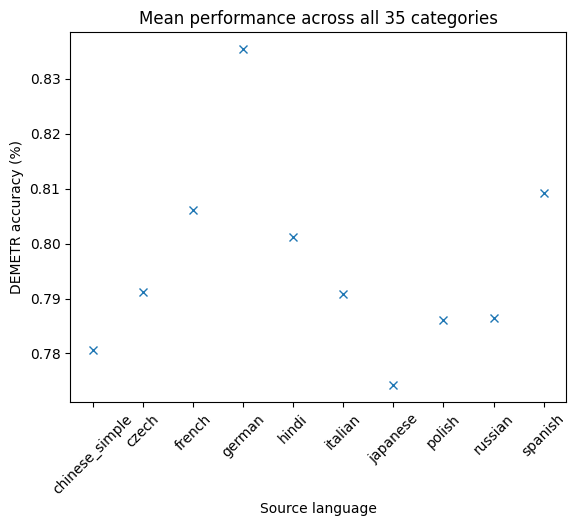

In [98]:
fig, axs = plt.subplots()
by_language = all_res.groupby('source_language')['correct'].mean()
axs.plot(by_language, 'x')
plt.xticks(np.arange(10), by_language.index, rotation=45)
plt.ylabel('DEMETR accuracy (%)')
plt.xlabel('Source language')
plt.title('Mean performance across all 35 categories')

Text(0.5, 1.0, 'Mean performance for each error type')

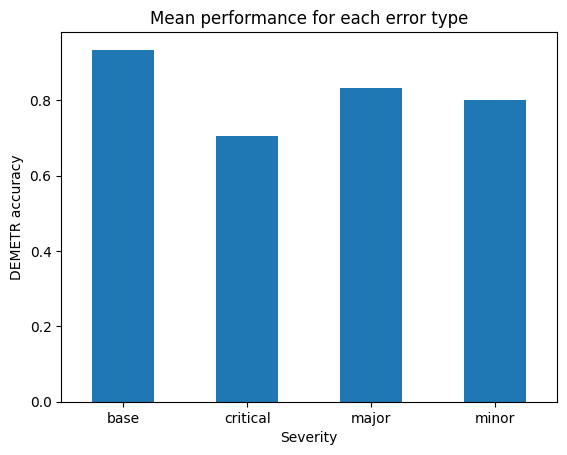

In [99]:
fig, axs = plt.subplots()
by_severity = all_res.groupby('severity')['correct'].mean()
by_severity.plot(kind='bar')
plt.xticks(np.arange(4), by_severity.index, rotation=0)
plt.ylabel('DEMETR accuracy')
plt.xlabel('Severity')
plt.title('Mean performance for each error type')

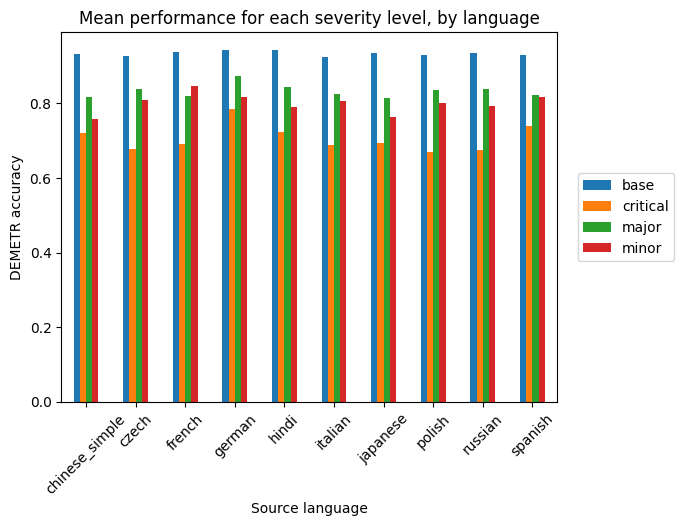

In [35]:
fig, axs = plt.subplots()
sev_by_lang = all_res.groupby(['source_language', 'severity'])['correct'].mean()
sev_by_lang.unstack().plot(kind='bar', ax=axs)
plt.xticks(rotation=45)
plt.ylabel('DEMETR accuracy')
plt.xlabel('Source language')
plt.title('Mean performance for each severity level, by language')
plt.legend(loc='right', bbox_to_anchor=(1.25, 0.5))




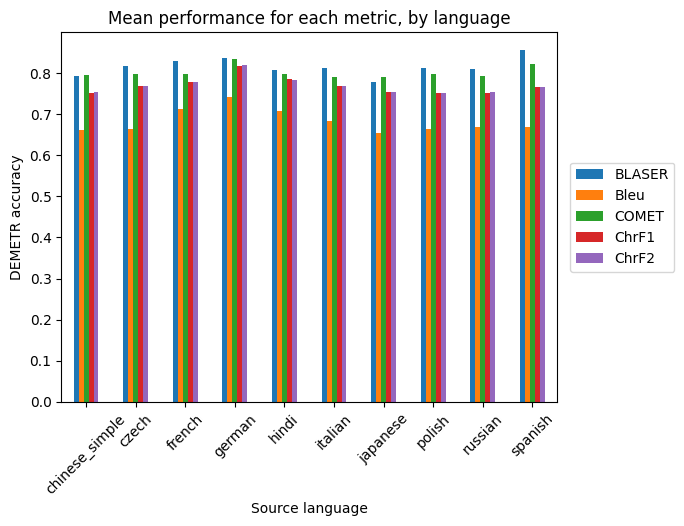

In [258]:
fig, axs = plt.subplots()
sev_by_lang = all_res.groupby(['source_language', 'metric'])['correct'].mean()
sev_by_lang.unstack().plot(kind='bar', ax=axs)
plt.xticks(rotation=45)
plt.ylabel('DEMETR accuracy')
plt.xlabel('Source language')
plt.title('Mean performance for each metric, by language')
plt.legend(loc='right', bbox_to_anchor=(1.25, 0.5))


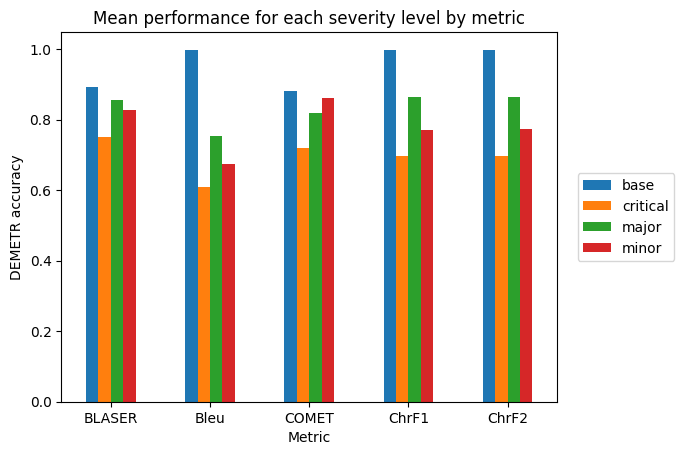

In [36]:
fig, axs = plt.subplots()
sev_by_lang = all_res.groupby(['metric', 'severity'])['correct'].mean()
sev_by_lang.unstack().plot(kind='bar', ax=axs)
plt.xticks(rotation=0)
plt.ylabel('DEMETR accuracy')
plt.xlabel('Metric')
plt.title('Mean performance for each severity level by metric')
plt.legend(loc='right', bbox_to_anchor=(1.25, 0.5))

### Comparison between M4ST and original paper

In [37]:
comet_baseline.head(5)

,metric,type,accuracy,category
9,Comet,learned,99.1,1
22,Comet,learned,100.0,2
35,Comet,learned,91.2,3
48,Comet,learned,99.2,4
61,Comet,learned,95.5,5


In [38]:
bleu_baseline.head(5)

,metric,type,accuracy,category
0,Bleu,string,93.2,1
13,Bleu,string,95.7,2
26,Bleu,string,69.5,3
39,Bleu,string,73.1,4
52,Bleu,string,79.2,5


In [39]:
all_res.head(5)

,source_language,mt_score,disfluent_score,metric,sentence_id,category,correct,severity
1,chinese_simple,73.613919,19.173356,ChrF1,1,33,True,base
2,chinese_simple,82.892551,17.013595,ChrF1,2,33,True,base
3,chinese_simple,71.757296,18.575202,ChrF1,3,33,True,base
4,chinese_simple,72.900449,13.572237,ChrF1,4,33,True,base
5,chinese_simple,53.857323,18.03467,ChrF1,5,33,True,base


In [40]:
m4st_blaser = all_res[all_res.metric == "BLASER"].groupby('category').correct.mean()*100
m4st_comet = all_res[all_res.metric == "COMET"].groupby('category').correct.mean()*100
m4st_bleu = all_res[all_res.metric == "Bleu"].groupby('category').correct.mean()*100

In [41]:
diff_paper = np.array(m4st_blaser) - np.array(comet_baseline.accuracy)
diff_new = np.array(m4st_blaser) - np.array(m4st_comet)

Text(0.5, 0, 'DEMETR category')

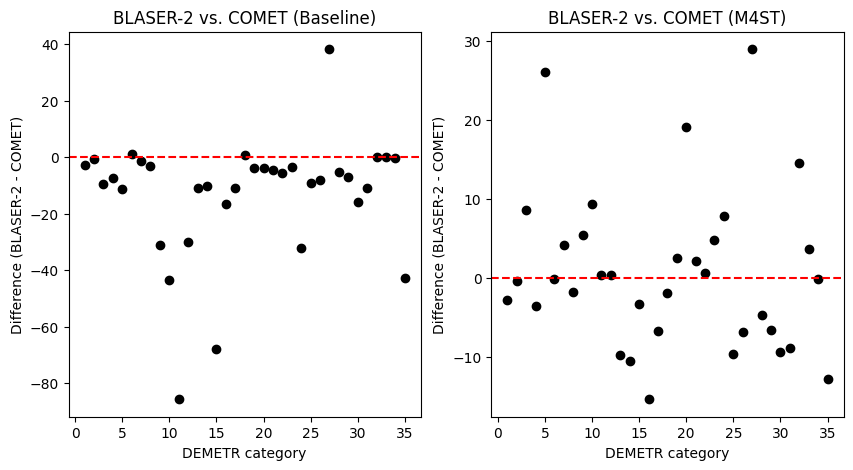

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(list(range(1, 36)), diff_paper, 'ko')
axs[0].axhline(0, linestyle='--', c='r')
axs[0].set_title("BLASER-2 vs. COMET (Baseline)")
axs[0].set_ylabel("Difference (BLASER-2 - COMET)")
axs[0].set_xlabel("DEMETR category")

axs[1].plot(list(range(1, 36)), diff_new, 'ko')
axs[1].axhline(0, linestyle='--', c='r')
axs[1].set_title("BLASER-2 vs. COMET (M4ST)")
axs[1].set_ylabel("Difference (BLASER-2 - COMET)")
axs[1].set_xlabel("DEMETR category")

In [43]:
diff_paper = np.array(m4st_blaser) - np.array(bleu_baseline.accuracy)
diff_new = np.array(m4st_blaser) - np.array(m4st_bleu)

Text(0.5, 0, 'DEMETR category')

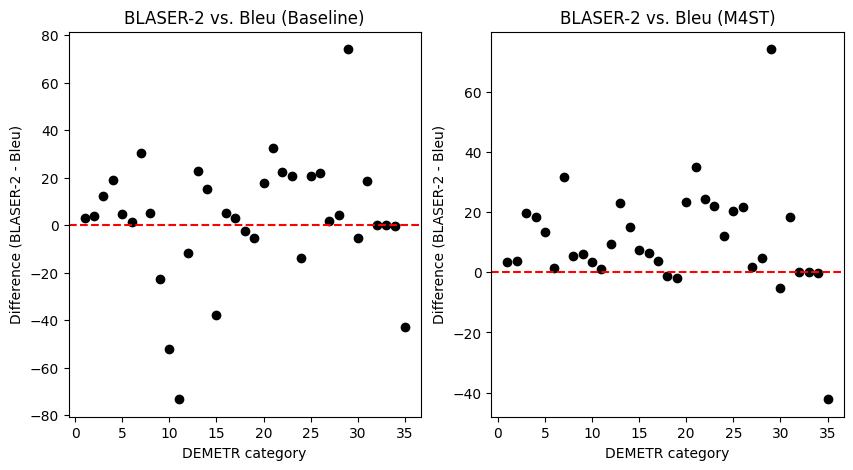

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(list(range(1, 36)), diff_paper, 'ko')
axs[0].axhline(0, linestyle='--', c='r')
axs[0].set_title("BLASER-2 vs. Bleu (Baseline)")
axs[0].set_ylabel("Difference (BLASER-2 - Bleu)")
axs[0].set_xlabel("DEMETR category")

axs[1].plot(list(range(1, 36)), diff_new, 'ko')
axs[1].axhline(0, linestyle='--', c='r')
axs[1].set_title("BLASER-2 vs. Bleu (M4ST)")
axs[1].set_ylabel("Difference (BLASER-2 - Bleu)")
axs[1].set_xlabel("DEMETR category")

### Compare BLASER to Bleu/COMET

In [69]:
demetr_df.head(1)

,metric,type,accuracy,category
0,Bleu,string,93.2,1


In [70]:
demetr_df['metric'] = demetr_df.metric.replace({'Comet': 'COMET', 'ChrF': 'ChrF1'})

In [71]:
np.unique(all_res.metric)

array(['BLASER', 'Bleu', 'COMET', 'ChrF1', 'ChrF2'], dtype=object)

In [72]:
np.unique(demetr_df.metric)

array(['BERTScore', 'Bleu', 'Bleurt20', 'CER', 'COMET', 'ChrF1', 'ChrF2',
       'Comet-QE', 'Meteor', 'PRISM', 'Prism', 'Prism-QE', 'Rouge2',
       'TER'], dtype=object)

In [73]:
# Subset DEMETR paper results to match the metrics I used
demetr_df_match = demetr_df[demetr_df.metric.isin(np.unique(all_res.metric))]

In [74]:
demetr_df_match

,metric,type,accuracy,category
0,Bleu,string,93.2,1
2,ChrF1,string,89.9,1
3,ChrF2,string,92.7,1
9,COMET,learned,99.1,1
13,Bleu,string,95.7,2
...,...,...,...,...
438,COMET,learned,100.0,34
442,Bleu,string,100.0,35
444,ChrF1,string,100.0,35
445,ChrF2,string,100.0,35


In [75]:
m4st_by_cat = all_res[['metric', 'category', 'correct']].groupby(['category', 'metric'])
m4st_by_cat = m4st_by_cat.correct.mean().reset_index()

In [76]:
m4st_by_cat

,category,metric,correct
0,1,BLASER,0.9640
1,1,Bleu,0.9310
2,1,COMET,0.9925
3,1,ChrF1,0.9150
4,1,ChrF2,0.9270
...,...,...,...
170,35,BLASER,0.5720
171,35,Bleu,0.9940
172,35,COMET,0.7010
173,35,ChrF1,0.9940


In [77]:
# Adjust percentage
m4st_by_cat['correct'] = m4st_by_cat['correct'] * 100

In [78]:
# Add column for plotting by source
demetr_df_match['source'] = 'Karpinska et al.'

/var/folders/z4/mf_7gqbs75d6y4sj_xb9t80w0000gr/T/ipykernel_77707/3352759439.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demetr_df_match['source'] = 'Karpinska et al.'


In [79]:
m4st_by_cat['source'] = 'ARC'
m4st_by_cat = m4st_by_cat.rename(columns={"correct": "accuracy"})

In [80]:
merged = pd.merge(demetr_df_match,
                  m4st_by_cat,
                  on=['category', 'metric', 'source', 'accuracy'], how='outer')

In [81]:
merged

,metric,type,accuracy,category,source
0,BLASER,NaN,96.40,1,ARC
1,Bleu,NaN,93.10,1,ARC
2,Bleu,string,93.20,1,Karpinska et al.
3,COMET,NaN,99.25,1,ARC
4,COMET,learned,99.10,1,Karpinska et al.
...,...,...,...,...,...
310,COMET,learned,100.00,35,Karpinska et al.
311,ChrF1,NaN,99.40,35,ARC
312,ChrF1,string,100.00,35,Karpinska et al.
313,ChrF2,NaN,99.40,35,ARC


In [82]:
merged = merged[merged.metric.isin(['Bleu', 'COMET', 'ChrF1', 'ChrF2'])]

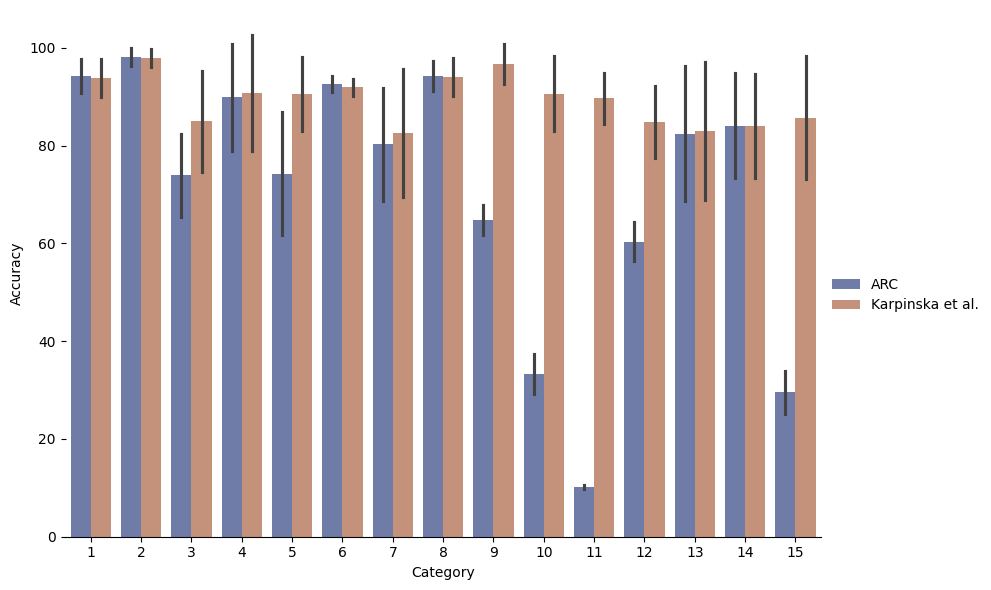

In [83]:
g = sns.catplot(
    data=merged[merged.category <=15], kind="bar",
    x="category", y="accuracy", hue="source",
    errorbar="sd", palette="dark", alpha=.6, height=6, aspect=11.7/8.27,
)
g.despine(left=True)
g.set_axis_labels("Category", "Accuracy")
g.legend.set_title("")

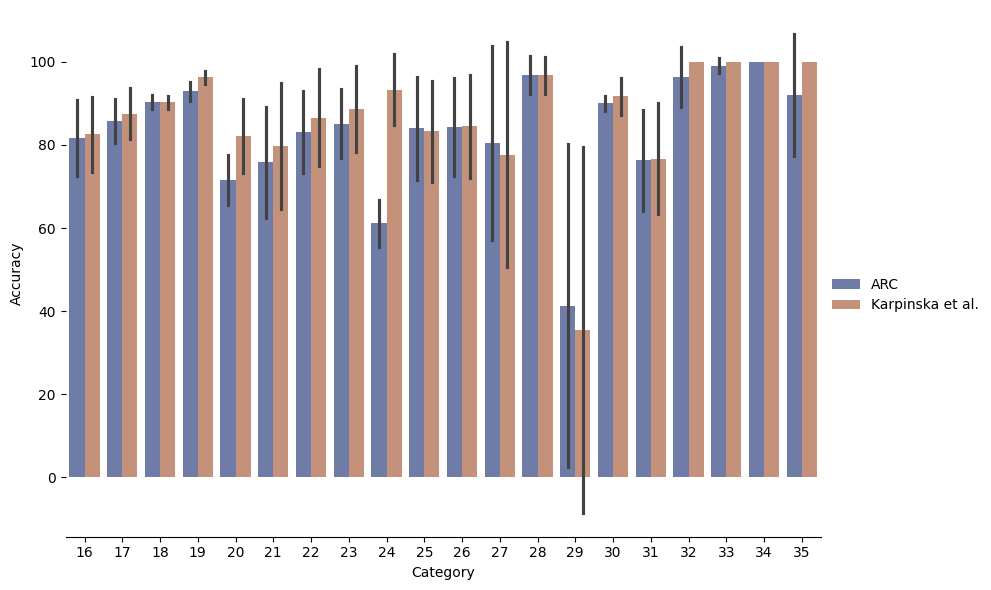

In [84]:
g = sns.catplot(
    data=merged[merged.category >15], kind="bar",
    x="category", y="accuracy", hue="source",
    errorbar="sd", palette="dark", alpha=.6, height=6, aspect=11.7/8.27,
)
g.despine(left=True)
g.set_axis_labels("Category", "Accuracy")
g.legend.set_title("")

### BLASER only

In [356]:
m4st_res_dir = "../outputs/demetr"

In [357]:
blaser_new_15 = pd.read_json(os.path.join(m4st_res_dir,
                                          "BLASER_REF_minor_id15_case.json"))
blaser_new_8 = pd.read_json(os.path.join(m4st_res_dir,
                                         "BLASER_Ref_critical_id8_negation.json"))
blaser_new_6 = pd.read_json(os.path.join(m4st_res_dir,
                                         "BLASER_Ref_critical_id6_addition.json"))

In [358]:
blaser_new_15

,601,602,603,604,605,606,607,608,609,610,...,91,92,93,94,95,96,97,98,99,100
source_language,czech,czech,czech,czech,czech,czech,czech,czech,czech,czech,...,chinese_simple,chinese_simple,chinese_simple,chinese_simple,chinese_simple,chinese_simple,chinese_simple,chinese_simple,chinese_simple,chinese_simple
mt_score,4.046928,4.642903,3.852083,4.719626,4.103452,4.689804,4.356555,4.806304,4.154267,4.999514,...,4.488197,4.385789,4.955001,4.806337,3.930781,4.203106,4.102276,4.280562,4.1981,4.09699
disfluent_score,4.046928,4.642903,3.852083,4.695207,4.10752,4.689804,4.049302,4.806304,4.154267,4.999514,...,4.488197,4.259297,4.955001,4.646544,3.930781,4.203106,4.102276,4.256535,4.1981,3.975805


In [361]:
blaser_new_15 = blaser_new_15.T
blaser_new_8 = blaser_new_8.T
blaser_new_6 = blaser_new_6.T

In [362]:
blaser_new_8

,source_language,mt_score,disfluent_score
602,czech,4.642903,4.572214
603,czech,3.852083,3.822893
604,czech,4.719626,4.607917
605,czech,4.103452,4.075375
606,czech,4.689804,4.556154
...,...,...,...
96,chinese_simple,4.203106,4.122562
97,chinese_simple,4.102276,4.035523
98,chinese_simple,4.280562,4.143666
99,chinese_simple,4.1981,4.074596


In [363]:
np.unique(blaser_new_15.source_language)

array(['chinese_simple', 'czech', 'french', 'german', 'hindi', 'italian',
       'japanese', 'polish', 'russian', 'spanish'], dtype=object)

In [364]:
blaser_new_15['diff'] = blaser_new_15.mt_score - blaser_new_15.disfluent_score
blaser_new_8['diff'] = blaser_new_8.mt_score - blaser_new_8.disfluent_score
blaser_new_6['diff'] = blaser_new_6.mt_score - blaser_new_6.disfluent_score

In [365]:
blaser_new_15

,source_language,mt_score,disfluent_score,diff
601,czech,4.046928,4.046928,0.0
602,czech,4.642903,4.642903,0.0
603,czech,3.852083,3.852083,0.0
604,czech,4.719626,4.695207,0.02442
605,czech,4.103452,4.10752,-0.004068
...,...,...,...,...
96,chinese_simple,4.203106,4.203106,0.0
97,chinese_simple,4.102276,4.102276,0.0
98,chinese_simple,4.280562,4.256535,0.024027
99,chinese_simple,4.1981,4.1981,0.0


([<matplotlib.axis.XTick at 0x32e458d50>,
 [Text(0, 0, 'chinese_simple'),
  Text(1, 0, 'czech'),
  Text(2, 0, 'french'),
  Text(3, 0, 'german'),
  Text(4, 0, 'hindi'),
  Text(5, 0, 'italian'),
  Text(6, 0, 'japanese'),
  Text(7, 0, 'polish'),
  Text(8, 0, 'russian'),
  Text(9, 0, 'spanish')])

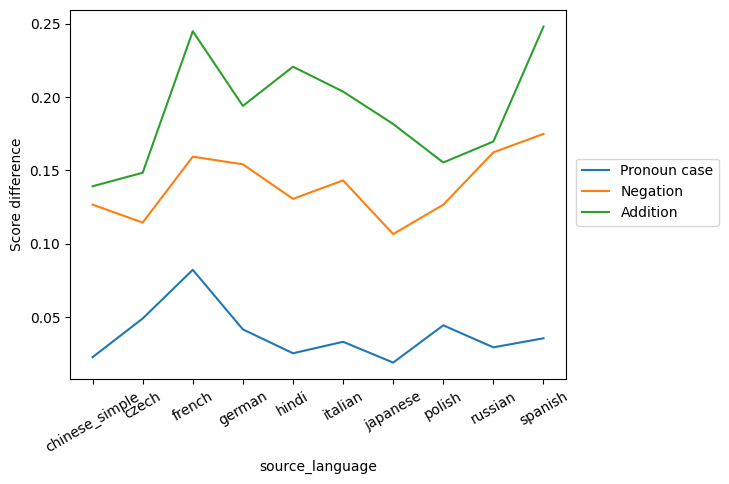

In [366]:
fig, axs = plt.subplots()
blaser_new_15.groupby('source_language').mean()['diff'].plot(ax=axs)
blaser_new_8.groupby('source_language').mean()['diff'].plot(ax=axs)
blaser_new_6.groupby('source_language').mean()['diff'].plot(ax=axs)

fig.legend(labels=['Pronoun case', 'Negation', 'Addition'],
           loc='right',
           bbox_to_anchor=(1.15, 0.5))
axs.set_ylabel("Score difference")
plt.xticks(np.arange(10), np.unique(blaser_new_15.source_language), rotation=30)